In [2]:
import os
import torch
from prepare_datasets import prepare_datasets
from build_dataloader import set_seed
from model import GAT
from model_GCN import GCN
from explain_model import explain_model

c:\Users\barbo\brain classifier repo\brain_classifier\.venv\lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
c:\Users\barbo\brain classifier repo\brain_classifier\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Set random seed for reproducibility
set_seed(42)
base_dir = os.path.dirname(os.getcwd())

In [5]:

# Prepare datasets
datasets, feature_names_sc, feature_names_combined = prepare_datasets(base_dir, test_size = 0.15, random_state = 42)

In [6]:
dataset_name = 'sc'
train_graphs = datasets[f'train_graphs_{dataset_name}']
train_labels = datasets[f'train_labels_{dataset_name}']
test_graphs = datasets[f'test_graphs_{dataset_name}']
test_labels = datasets[f'test_labels_{dataset_name}']

In [7]:
param_grid_1 = { 
    'num_heads': [1,2,3],
    'out_channels': [8],
    'learning_rate': [0.01, 0.001],
    'weight_decay': [0]
}

Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 1, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stopping triggered at epoch 30 in fold 1
Starting fold 2/5
Early stopping triggered at epoch 39 in fold 2
Starting fold 3/5
Early stopping triggered at epoch 21 in fold 3
Starting fold 4/5
Early stopping triggered at epoch 28 in fold 4
Starting fold 5/5
Early stopping triggered at epoch 28 in fold 5
Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 2, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stopping triggered at epoch 18 in fold 1
Starting fold 2/5
Early stopping triggered at epoch 18 in fold 2
Starting fold 3/5
Early stopping triggered at epoch 35 in fold 3
Starting fold 4/5
Early stopping triggered at epoch 15 in fold 4
Starting fold 5/5
Early stopping triggered at epoch 28 in fold 5
Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 3, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stopping

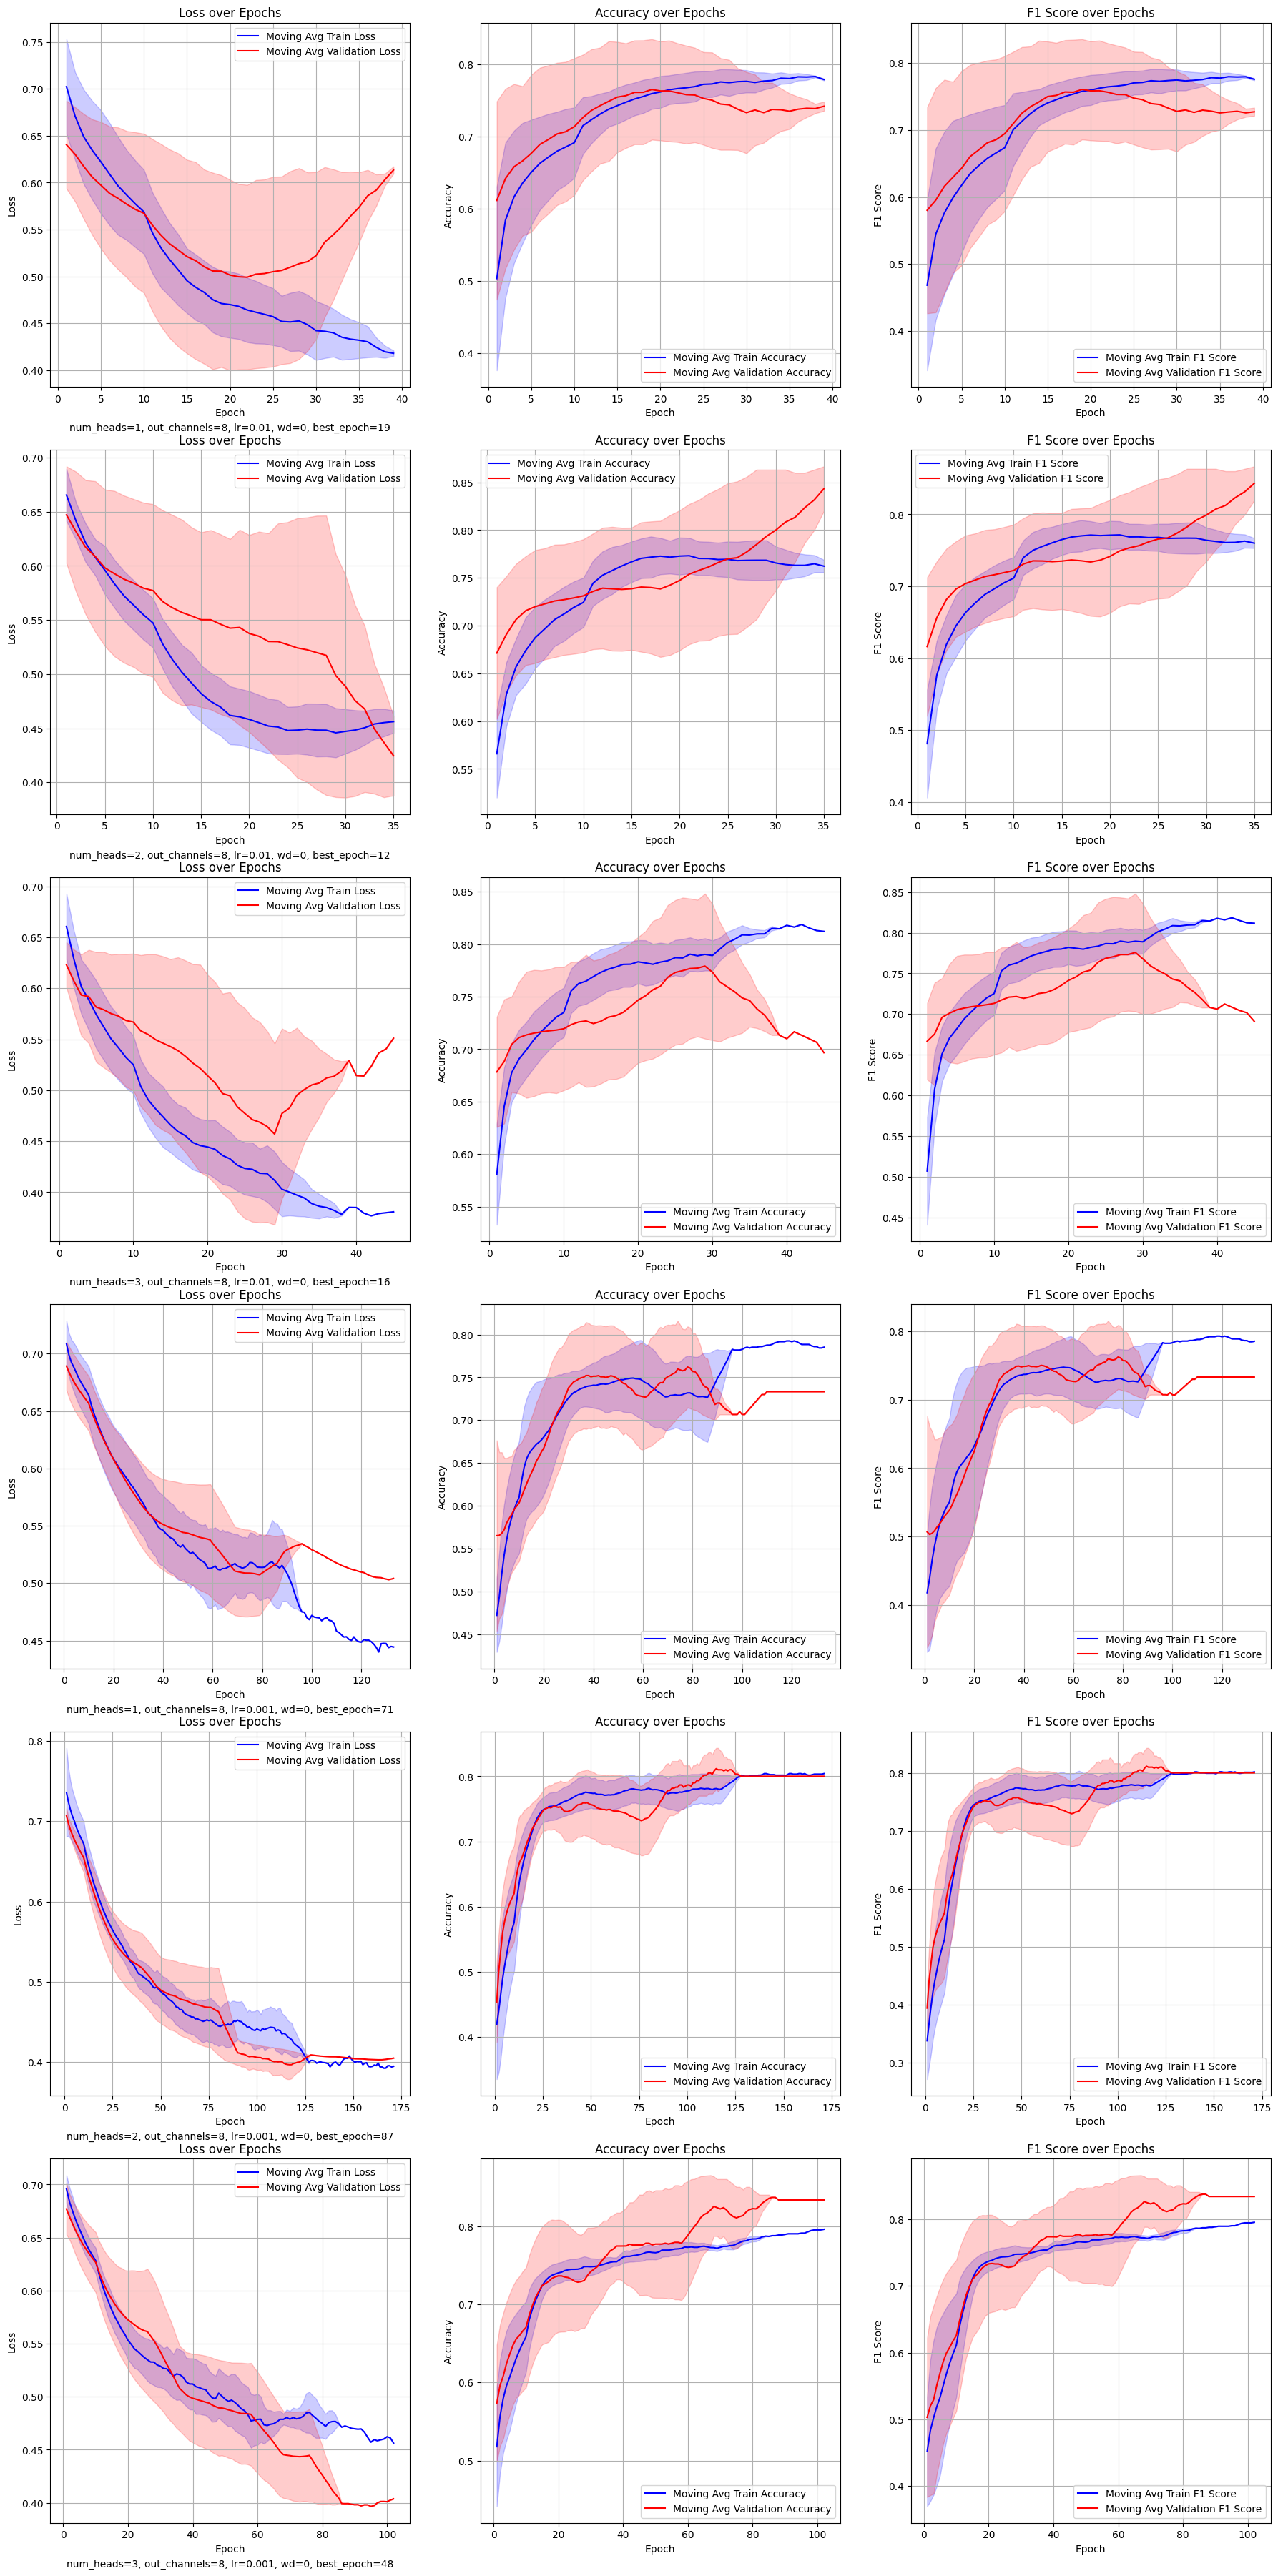

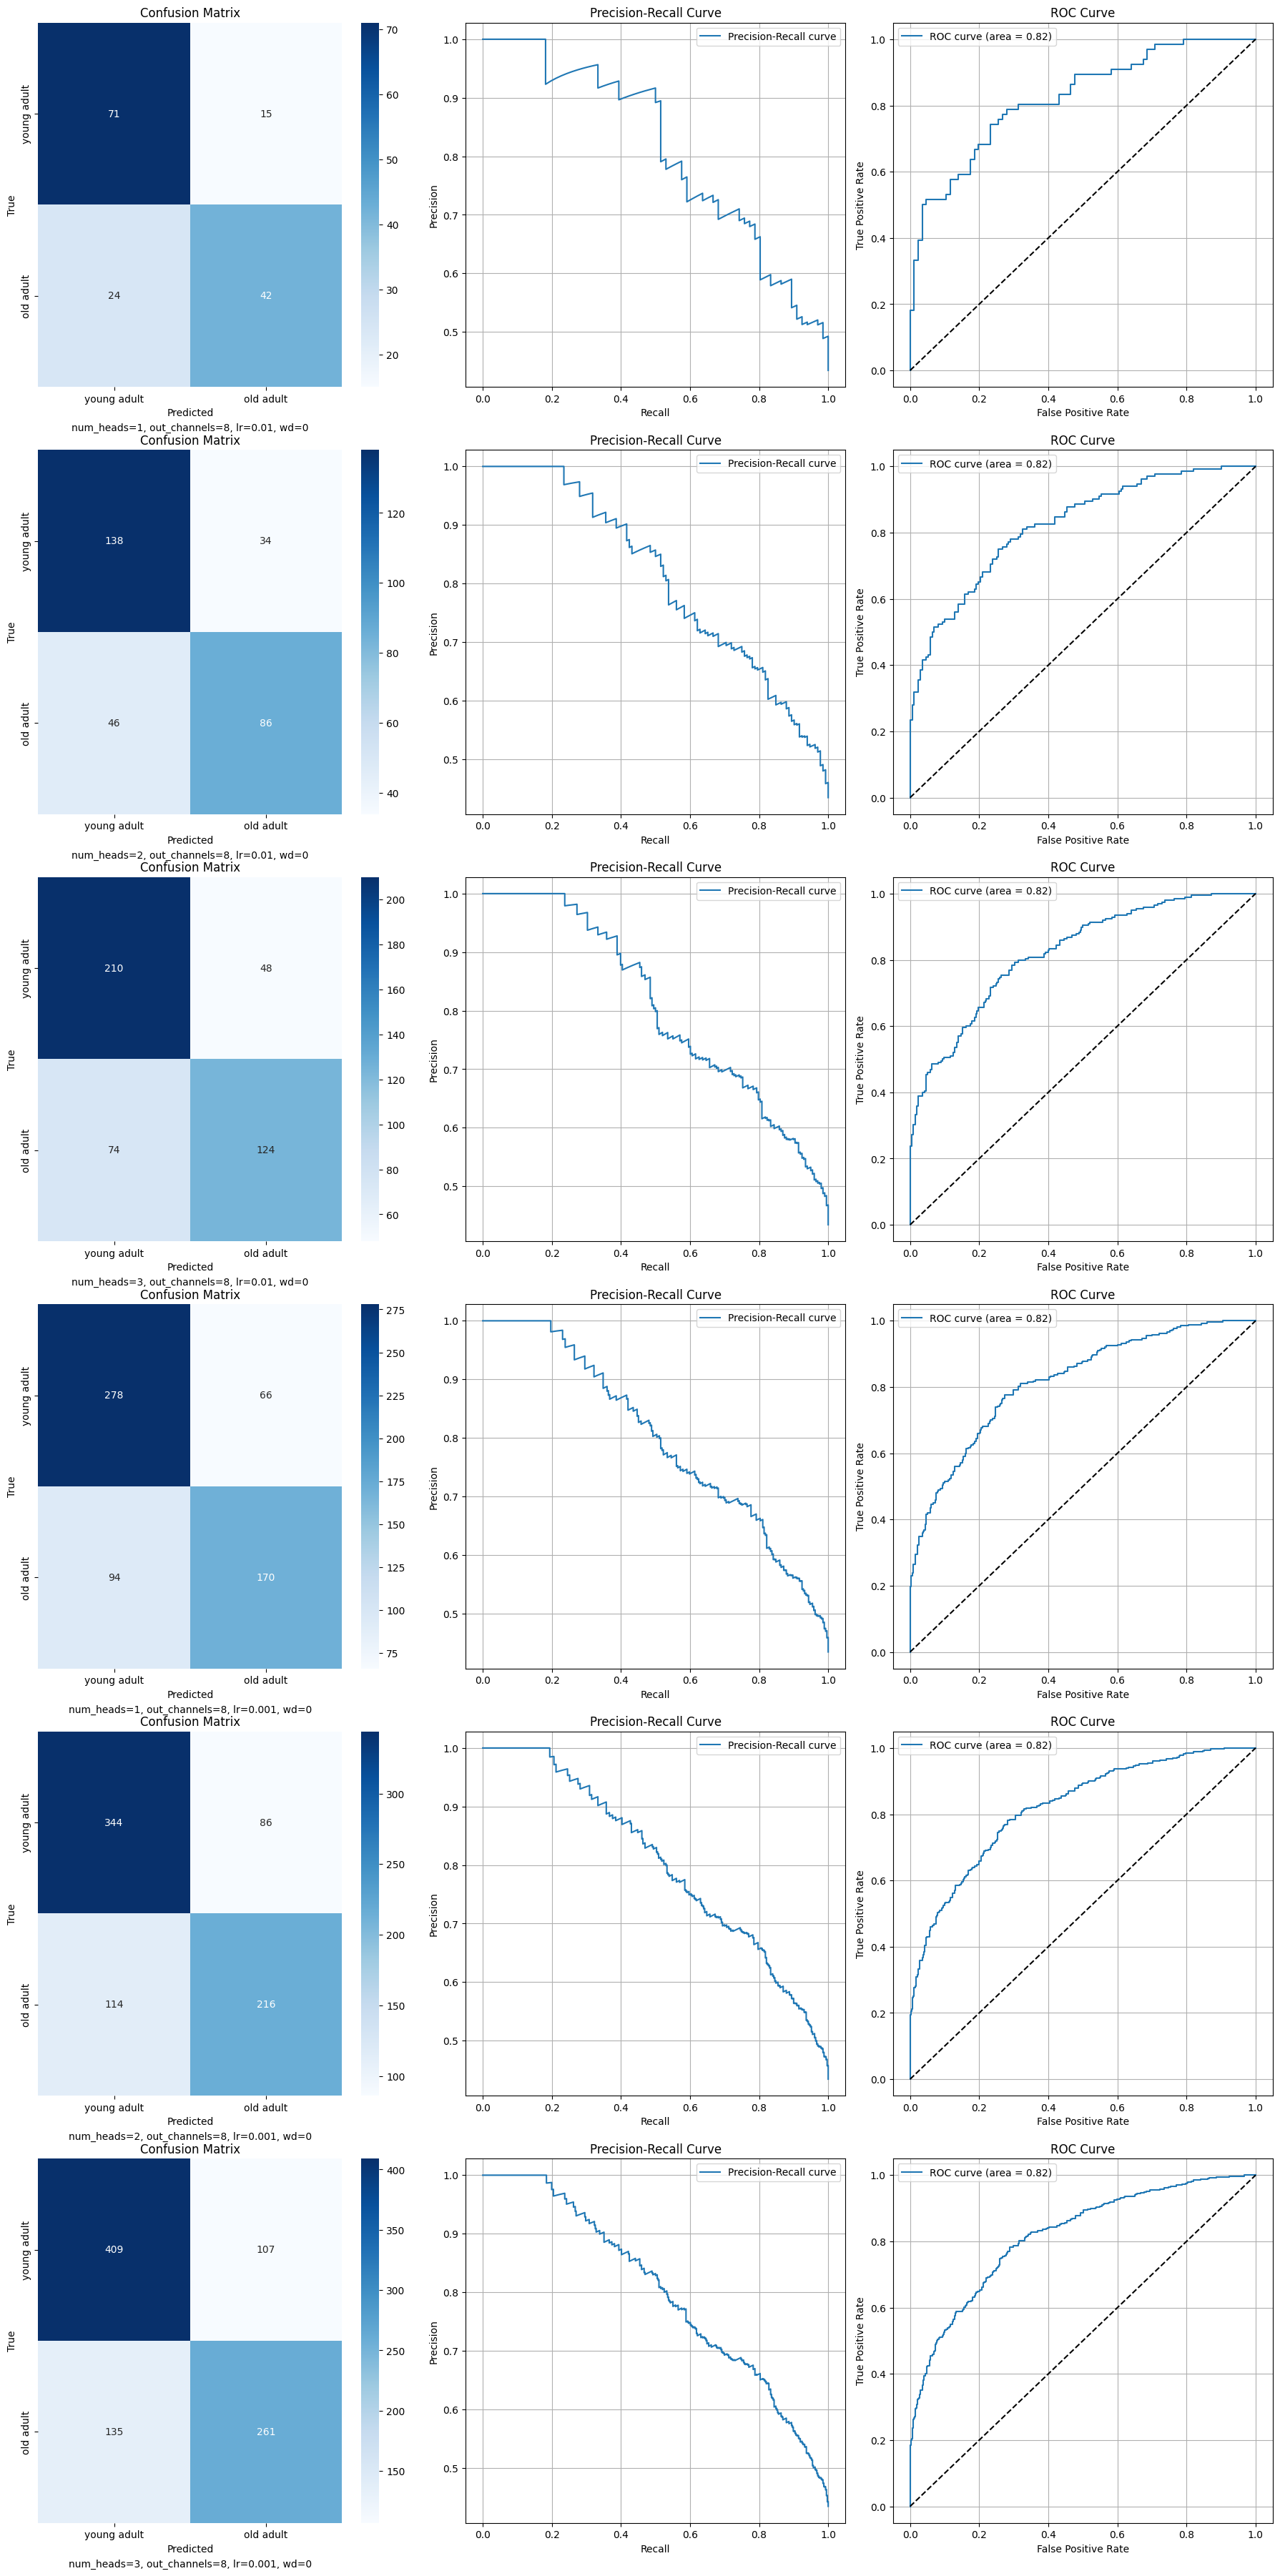

In [8]:
from perform_cv_early_stopping import perform_cv_early_stopping
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Perform grid search with K-fold cross-validation on the training set
best_params_1, best_val_f1_1, best_val_accuracy_1, best_epochs_trained_1, results_df_1 = perform_cv_early_stopping(
    train_graphs=train_graphs,
    train_labels=train_labels,
    num_splits=5,
    param_grid=param_grid_1,
    model_class=GAT,
    batch_size=8,
    device=device,
    patience = 10,
    max_epochs = 300
)


In [10]:
print("Best Hyperparameters (based on average validation F1):")
print(best_params_1)
print(f"Best Average Validation F1 Score: {best_val_f1_1}")
print(f"Best Average Validation Accuracy: {best_val_accuracy_1}")

Best Hyperparameters (based on average validation F1):
{'num_heads': 1.0, 'out_channels': 8.0, 'learning_rate': 0.01, 'weight_decay': 0.0}
Best Average Validation F1 Score: 0.7644518822798612
Best Average Validation Accuracy: 0.7636559139784946


In [ ]:
# Save results_df to a CSV file for later analysis
#results_df_1.to_csv('first_grid_search_sc.csv', index=False)

In [19]:
best_params = {
    'num_heads': 1,
    'out_channels': 8,
    'learning_rate': 0.01,
    'weight_decay': 0
}

Epoch 1/19: Loss: 0.6325, F1: 0.6393
Epoch 2/19: Loss: 0.6111, F1: 0.7057
Epoch 3/19: Loss: 0.5938, F1: 0.7489
Epoch 4/19: Loss: 0.5736, F1: 0.7608
Epoch 5/19: Loss: 0.5576, F1: 0.7568
Epoch 6/19: Loss: 0.5629, F1: 0.7621
Epoch 7/19: Loss: 0.5488, F1: 0.7724
Epoch 8/19: Loss: 0.5489, F1: 0.7509
Epoch 9/19: Loss: 0.5494, F1: 0.7440
Epoch 10/19: Loss: 0.5299, F1: 0.7741
Epoch 11/19: Loss: 0.5192, F1: 0.7558
Epoch 12/19: Loss: 0.5090, F1: 0.7763
Epoch 13/19: Loss: 0.5062, F1: 0.7895
Epoch 14/19: Loss: 0.5098, F1: 0.7621
Epoch 15/19: Loss: 0.4987, F1: 0.7891
Epoch 16/19: Loss: 0.4818, F1: 0.8081
Epoch 17/19: Loss: 0.4744, F1: 0.7678
Epoch 18/19: Loss: 0.4735, F1: 0.7568
Epoch 19/19: Loss: 0.4630, F1: 0.7615


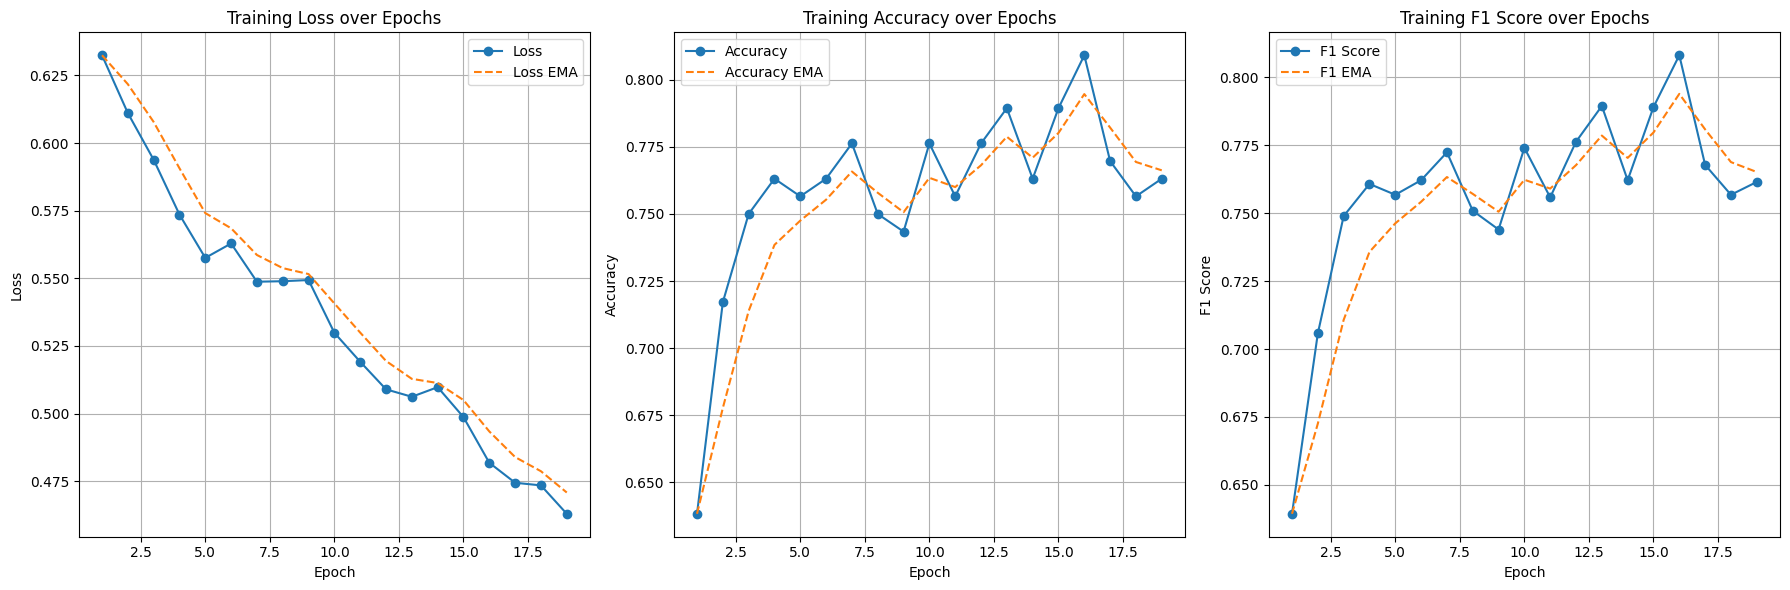

In [20]:
# train on all data

from train_all_data import train_model_on_all_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model_on_all_data( 
    train_graphs, 
    train_labels, 
    dataset_name='sc',
    best_params = best_params, 
    model_class = GAT,
    max_epochs = 19, 
    batch_size=8, 
    device = device)

In [7]:
from prepare_datasets import compute_feature_means_stds, compute_edge_attr_means_stds, normalize_graph_features, normalize_graph_edge_weights

train_mean_x, train_std_x = compute_feature_means_stds(train_graphs)
train_mean_edge_attr, train_std_edge_attr = compute_edge_attr_means_stds(train_graphs)

In [10]:
best_model_path = os.path.join(base_dir, 'src2', 'best_model_sc.pth')


from test_best_model import test_model

test_model(
    model_path=best_model_path,
    graphs=test_graphs,
    labels=test_labels,
    model_class=GAT,
    train_mean_x=train_mean_x,
    train_std_x=train_std_x,
    train_mean_edge_attr=train_mean_edge_attr,
    train_std_edge_attr=train_std_edge_attr,
    batch_size=8
)

Test Loss: 0.4596, Test Accuracy: 0.8148, Test F1: 0.8153


In [ ]:
# Benchmarking with GCN

from model_GCN import GCN

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Perform grid search with K-fold cross-validation on the training set
best_params_1, best_val_f1_1, best_val_accuracy_1, best_epochs_trained_1, results_df_1 = perform_cv_early_stopping(
    train_graphs=train_graphs,
    train_labels=train_labels,
    num_splits=5,
    param_grid=param_grid_1,
    model_class=GCN,
    batch_size=8,
    device=device,
    patience = 10,
    max_epochs = 200
)

In [ ]:
# Set the best hyperparameters
best_params_2 = {
    'num_heads': 3,
    'out_channels': 8,
    'learning_rate': 0.01,
    'weight_decay': 0
}

In [ ]:
# Train the best model on all data
# train on all data

from train_all_data import train_model_on_all_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model_on_all_data( 
    train_graphs, 
    train_labels, 
    dataset_name='sc_gcn',
    best_params = best_params_2, 
    model_class=GCN,
    max_epochs = 24, 
    batch_size=8, 
    device = device)

In [ ]:
best_model_path = os.path.join(base_dir, 'src1', 'best_model_sc_gcn.pth')


from test_best_model import test_model
test_model(
    model_path=best_model_path,
    graphs=test_graphs,
    labels=test_labels,
    model_class=GCN,
    train_mean_x=train_mean_x,
    train_std_x=train_std_x,
    train_mean_edge_attr=train_mean_edge_attr,
    train_std_edge_attr=train_std_edge_attr,
    batch_size=8
)